In [1]:
# Modify the file A00_setup.  Note the working directory is changed
import os
os.chdir(os.getcwd().rsplit(os.path.sep + 'code')[0] + os.path.sep + 'code')
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./A_target_count_encoding/A00_setup.py").load_module()
os.getcwd()

'/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code'

# XGB / Target+Count Enc / DGI groups: Vary hierarchy (pairs), More Groups
Do an alternative hierarchical blending, NAICS + one group code.  All DGI cluster sizes k

*This script takes about 5 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import pickle

In [3]:
from pathlib import Path

In [4]:
import sklearn as sk
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance, partial_dependence
from scikitplot.metrics import plot_lift_curve

In [5]:
from sba_gnn.sba_gnn import sg_plot, sg_target_count_encoder
from sba_gnn.sba_gnn.sg_target_count_encoder import TargetCountEncoder

## Import Processed Datasets

In [6]:
sba_loans = pd.read_parquet(Path(setup.parent_path).joinpath('01_DATA_transformed.parquet')) 

In [7]:
best_params_df = pd.read_csv(Path(setup.parent_path).joinpath('03_REPORT_fit_parameter_selected.csv'))
best_params = best_params_df.to_dict(orient='records')[0]
best_params

{'subsample': 0.8,
 'scale_pos_weight': 1.0,
 'reg_lambda': 0.01,
 'reg_alpha': 0.001,
 'min_child_weight': 50,
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 2}

In [8]:
xgb_params = dict(best_params, 
                   **{'objective':"binary:logistic", 'n_estimators':setup.xgb_n_estimators})

##### Append DGI info

In [9]:
##### DGI info
embed_df = pd.read_parquet(Path(setup.parent_path).joinpath('63_DATA_embeddings_tsne_naics.parquet'))

In [10]:
# Group counts
naics_grp_counts = pd.read_csv(Path(setup.parent_path).joinpath('02_REPORT_naics_grp_stats_all.csv')) \
    [['level_0', 'count_grp']] \
    .drop_duplicates() \
    .set_axis(['naics_type', 'k'], axis=1)

In [11]:
naics_grp_k = naics_grp_counts['k'].drop_duplicates().sort_values().to_list()
naics_grp_k

[20.0, 106.0, 354.0, 834.0]

In [12]:
cluster_cols = sorted([c for c in embed_df if c.startswith('cluster_')],
                      reverse=True)
cluster_cols

['cluster_834',
 'cluster_354',
 'cluster_106',
 'cluster_020',
 'cluster_010',
 'cluster_003']

In [13]:
sba_loans = sba_loans.drop(columns = cluster_cols, errors='ignore') \
    .merge(embed_df[['NAICS_orig'] + cluster_cols] \
               .rename(columns={'NAICS_orig':'NAICS'}),
           on='NAICS', how='left')

##### Comparison metrics

In [14]:
metrics_base = pd.read_csv(Path(setup.parent_path).joinpath('X68_REPORT_metrics.csv'))

In [15]:
# Regular, non-hierarchical target encoding, for a horizontal reference line
metrics_tenc = pd.read_csv(Path(setup.parent_path).joinpath('14_REPORT_metrics.csv'))

## Function to get metrics

In [16]:
def get_metrics(data, lambda_k = setup.selected_lambda_k, enc_features = ['NAICS', 'NAICS_sector']):
    
    # Alternative encoding
    train_df = data[data['dset'] == 'train']
    enc_dict = {f:TargetCountEncoder(lambda_k = lambda_k) for f in enc_features}
    [enc_dict[f].fit(train_df[f], train_df['target']) for f in enc_features]
    enc_val = pd.concat([enc_dict[f].transform(data[f]) for f in enc_features],
                    axis=1, keys=enc_features)
    enc_val.columns = [c[0] + '_' + c[1] for c in enc_val.columns]
    
    # Append to data
    data = pd.concat([data.drop(columns=enc_val.columns, errors='ignore'), enc_val], 
                      axis=1)
    train_df = data[data['dset'] == 'train']
    test_df = data[data['dset'] == 'test']
    val_df = data[data['dset'] == 'val']
    
    predictor_features = setup.predictor_features + list(enc_val.columns)

    # Model fit
    xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators =  setup.xgb_n_estimators)
    xgb_model = xgb_model.set_params(**xgb_params)
    xgb_model.fit(train_df[predictor_features], train_df['target'],
              eval_set = [(train_df[predictor_features], train_df['target']),
                         (val_df[predictor_features], val_df['target'])])
    
    # Predict
    pred_df = pd.concat([data[['LoanNr_ChkDgt', 'dset', 'target', 'dset_naics_holdout']].reset_index(),
                     pd.DataFrame({'predict_prob':
                                   xgb_model.predict_proba(data[predictor_features])[:,1]})],
                    axis=1) \
    .set_index('index')
    
    # Decision threshold
    pred_train_df = pred_df[pred_df['dset'] == 'train']
    thresh_tune_data = sg_plot.get_f1_frame(pred_train_df['target'], 
                                        pred_train_df['predict_prob'])
    thresh_head = thresh_tune_data.sort_values('f1', ascending=False).head(2)
    best_thresh = thresh_head['thresh'].iloc[0]
    pred_df['predict_bin'] = np.where(pred_df['predict_prob'] >= best_thresh, 1, 0)
    
    # Metrics
    metrics_dset_df = pred_df.groupby('dset') \
        .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()
    metrics_test_df = pred_df[pred_df['dset'] == 'test'] \
        .groupby(['dset', 'dset_naics_holdout']) \
        .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()
    metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
    
    return pred_df, metrics_df

## Loop to get predictions, metrics

In [17]:
# Hierarchical encode from different levels
naics_sets = [['NAICS', cluster_cols[i]] \
              for i in range(len(cluster_cols))]
naics_sets

[['NAICS', 'cluster_834'],
 ['NAICS', 'cluster_354'],
 ['NAICS', 'cluster_106'],
 ['NAICS', 'cluster_020'],
 ['NAICS', 'cluster_010'],
 ['NAICS', 'cluster_003']]

In [18]:
%%capture
pred_df = pd.DataFrame()
metrics_df = pd.DataFrame()
for this_set in naics_sets:
    this_pred, this_met = get_metrics(sba_loans, enc_features=this_set)
    this_pred['naics_type'] = this_set[1]
    pred_df = pd.concat([pred_df, this_pred])
    this_met['naics_type'] = this_set[1]
    metrics_df = pd.concat([metrics_df, this_met])

In [19]:
metrics_df[metrics_df['dset_naics_holdout'] == 1]

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout,naics_type
1,test,0.664315,0.418966,0.305605,0.666018,0.346532,0.728545,1.0,cluster_834
1,test,0.645607,0.419441,0.298612,0.704509,0.342142,0.726314,1.0,cluster_354
1,test,0.629865,0.416969,0.292092,0.728365,0.338607,0.724225,1.0,cluster_106
1,test,0.636552,0.411763,0.291661,0.700025,0.323072,0.715017,1.0,cluster_020
1,test,0.628082,0.414416,0.290253,0.724220,0.325766,0.716358,1.0,cluster_010
1,test,0.618198,0.413544,0.286833,0.740800,0.332378,0.718843,1.0,cluster_003


In [20]:
metrics_df[metrics_df['dset_naics_holdout'] == 0]

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout,naics_type
0,test,0.659665,0.449590,0.336851,0.675753,0.383786,0.728718,0.0,cluster_834
0,test,0.660692,0.450338,0.337692,0.675753,0.384818,0.729493,0.0,cluster_354
0,test,0.661088,0.449500,0.337518,0.672684,0.384389,0.729432,0.0,cluster_106
0,test,0.660425,0.451132,0.337911,0.678458,0.384190,0.729613,0.0,cluster_020
0,test,0.659997,0.450326,0.337342,0.677106,0.384655,0.729495,0.0,cluster_010
0,test,0.658606,0.450321,0.336656,0.679863,0.383761,0.728957,0.0,cluster_003


In [21]:
pred_df.to_parquet(Path(setup.temp_path).joinpath('A09_DATA_combined_predictions.parquet'))
metrics_df.to_csv(Path(setup.temp_path).joinpath('A09_REPORT_metrics.csv'), index=True)

## Comparison Plot

In [22]:
col_map = {k:int(k.split('_')[1]) for k in cluster_cols}
label_k = sorted(col_map.values())

In [23]:
col_map

{'cluster_834': 834,
 'cluster_354': 354,
 'cluster_106': 106,
 'cluster_020': 20,
 'cluster_010': 10,
 'cluster_003': 3}

In [24]:
metrics_sum = metrics_df[~metrics_df['dset_naics_holdout'].isna()].copy()
metrics_sum['k'] = metrics_sum['naics_type'].apply(lambda x: col_map[x]).astype('int')

In [25]:
metrics_base_sum = metrics_base[~metrics_base['dset_naics_holdout'].isna()].copy()
metrics_base_sum['k'] = metrics_base_sum['start_naics'].apply(lambda x: col_map[x]).astype('int')

In [26]:
# Reference lines
hline_test = metrics_tenc[(metrics_tenc['dset_naics_holdout'] == 0) &
                          (metrics_tenc['c'] == setup.selected_lambda_k)] \
    ['average_precision_score'].iloc[0]
hline_ho = metrics_tenc[(metrics_tenc['dset_naics_holdout'] == 1) &
                          (metrics_tenc['c'] == setup.selected_lambda_k)] \
    ['average_precision_score'].iloc[0]
print(f'Regular target encoding test result: {hline_test}; holdout {hline_ho}')

Regular target encoding test result: 0.382950251407698; holdout 0.346336505844941


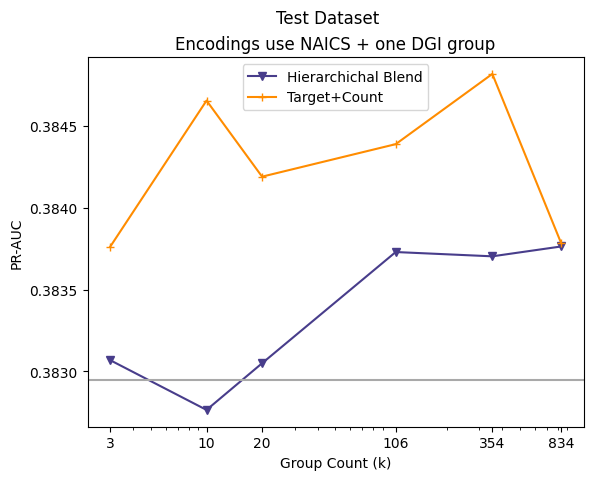

In [27]:
fig, ax = plt.subplots()
metrics_base_sum[metrics_base_sum['dset_naics_holdout'] == 0] \
    .plot(x='k', y='average_precision_score', logx=True, ax=ax, 
          label='Hierarchichal Blend',color='darkslateblue', style='v-')
metrics_sum[metrics_sum['dset_naics_holdout'] == 0] \
    .plot(x='k', y='average_precision_score', logx=True, ax=ax, 
          label='Target+Count',color='darkorange', style='+-')
ax.set_ylabel('PR-AUC')
ax.set_xlabel('Group Count (k)')
fig.suptitle('Test Dataset')
ax.set_title('Encodings use NAICS + one DGI group')
plt.axhline(y=hline_test, color='darkgray')
ax.set_xticks(label_k)
ax.set_xticklabels(label_k)
fig.savefig(Path(setup.temp_path).joinpath('A09_PLOT_compare_base_reg.png'),
            bbox_inches='tight')

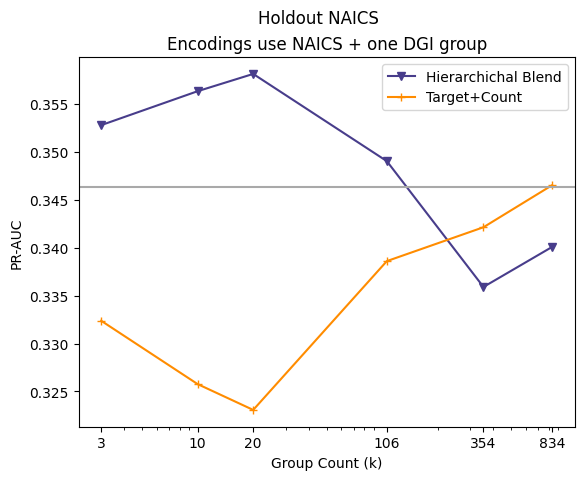

In [28]:
fig, ax = plt.subplots()
metrics_base_sum[metrics_base_sum['dset_naics_holdout'] == 1] \
    .plot(x='k', y='average_precision_score', logx=True, ax=ax, 
          label='Hierarchichal Blend',color='darkslateblue', style='v-')
metrics_sum[metrics_sum['dset_naics_holdout'] == 1] \
    .plot(x='k', y='average_precision_score', logx=True, ax=ax, 
          label='Target+Count',color='darkorange', style='+-')
ax.set_ylabel('PR-AUC')
ax.set_xlabel('Group Count (k)')
fig.suptitle('Holdout NAICS')
ax.set_title('Encodings use NAICS + one DGI group')
plt.axhline(y=hline_ho, color='darkgray')
ax.set_xticks(label_k)
ax.set_xticklabels(label_k)
fig.savefig(Path(setup.temp_path).joinpath('A09_PLOT_compare_base_ho.png'),
            bbox_inches='tight')